# Audiobook Generator - Proof of Concept

This notebook is intended to be a proof of concept for the end-to-end work of generating an audiobook file from an ebook. This includes converting the .epub book files into raw python trxt strings, splitting into items and sentences, then tokenizing and batching them to run through the Nvidia implementation of Tacotron2.


## Outline of steps

1. Import .epub file
2. Divide ebook into chapters
3. Remove html tags
4. Tokenize text for use in the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
from pydub import AudioSegment
from IPython.display import Audio
from tqdm.notebook import tqdm

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

/home/matthew/anaconda3/envs/ttsenv/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
ebook_path = 'pg2554.epub'
rate = 22050
batch_size = 100
max_char_len = 150

In [ ]:
# !pip install nvidia-pyindex
# !pip install pytorch-quantization

In [ ]:
### tacotron2 = torch.hub.load(
#     'NVIDIA/DeepLearningExamples:torchhub', 
#     'nvidia_tacotron2', 
#     model_math='fp16',  
#     map_location=torch.device(device)
# )
tacotron2 = torch.hub.load_state_dict_from_url(
    'https://ngc.nvidia.com/catalog/models/nvidia:tacotron2pyt_fp32/files?version=3', 
    map_location=torch.device(device)
)
tacotron2 = tacotron2.to(device)
# tacotron2 = tacotron2.eval()

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

waveglow = torch.hub.load(
    'NVIDIA/DeepLearningExamples:torchhub', 
    'nvidia_waveglow', 
    model_math='fp16',  
    map_location=torch.device(device)
)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow = waveglow.eval()

In [40]:
def read_ebook(ebook_path):
    
    import ebooklib
    from ebooklib import epub
    from bs4 import BeautifulSoup
    from tqdm.notebook import tqdm
    from nltk import tokenize, download
    from textwrap import TextWrapper
    
    download('punkt')
    wrapper = TextWrapper(max_char_len, fix_sentence_endings=True)
    
    book = epub.read_epub(ebook_path)

    corpus = []
    for item in tqdm(list(book.get_items())):
        if item.get_type() == ebooklib.ITEM_DOCUMENT:
            input_text = BeautifulSoup(item.get_content(), "html.parser").text
            text_list = []
            for paragraph in input_text.split('\n'):
                paragraph = paragraph.replace('—', '-')
                sentences = tokenize.sent_tokenize(paragraph)
                
                # Truncate sentences to maximum character limit
                sentence_list = []
                for sentence in sentences:
                    wrapped_sentences = wrapper.wrap(sentence)
                    sentence_list.append(wrapped_sentences)
                # Flatten list of list of sentences
                trunc_sentences = [phrase for sublist in sentence_list for phrase in sublist]
                
                text_list.append(trunc_sentences)
            text_list = [text for sentences in text_list for text in sentences]
            corpus.append(text_list)

    return corpus

In [41]:
ebook = read_ebook(ebook_path)

[nltk_data] Downloading package punkt to /home/matthew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/55 [00:00<?, ?it/s]

In [42]:
len(ebook)

50

In [43]:
ebook[6]

[' CHAPTER III',
 'He waked up late next day after a broken sleep.',
 'But his sleep had not refreshed him; he waked up bilious, irritable, ill-tempered, and looked with hatred at his room.',
 'It was a tiny cupboard of a room about six paces in length.',
 'It had a poverty-stricken appearance with its dusty yellow paper peeling off the walls, and it was so low-pitched that a man of more than average',
 'height was ill at ease in it and felt every moment that he would knock his head against the ceiling.',
 'The furniture was in keeping with the room: there were three old chairs, rather rickety; a painted table in the corner on which lay a few manuscripts',
 'and books; the dust that lay thick upon them showed that they had been long untouched.',
 'A big clumsy sofa occupied almost the whole of one wall and half the floor space of the room; it was once covered with chintz, but was now in rags and',
 'served Raskolnikov as a bed.',
 'Often he went to sleep on it, as he was, without undre

(array([1445., 2509., 2400., 1851., 1598., 1268., 1032.,  810.,  705.,
        2580.]),
 array([  1. ,  15.9,  30.8,  45.7,  60.6,  75.5,  90.4, 105.3, 120.2,
        135.1, 150. ]),
 <BarContainer object of 10 artists>)

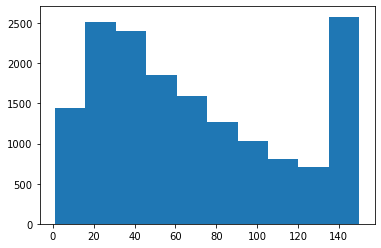

In [44]:
plt.hist([len(sentence) for chapter in ebook for sentence in chapter])

In [ ]:
text = ebook[6]
text = [sentence[:max_char_len] for sentence in text]
tokens, lengths = utils.prepare_input_sequence(text)

In [ ]:
lengths

In [ ]:
len(text)

In [ ]:
tokens.shape

In [ ]:
data = [(tokens[i],lengths[i]) for i in range(len(tokens))]

In [ ]:
dataloader = DataLoader(data, batch_size=6)

In [ ]:
len(dataloader)

In [ ]:
audio_list = []
for X, length in tqdm(dataloader):
    with torch.no_grad():
        Y, _, _ = tacotron2.infer(X, length)
        audio = waveglow.infer(Y)
        audio_list.append(audio)
#     audio_numpy = audio[0].data.cpu().numpy()

In [ ]:
!nvidia-smi

In [ ]:
50 * 2.5